In [1]:
# Импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
sns.set_style("whitegrid")

%matplotlib inline

SEED = 42

import sklearn
# from sklearn import metrics #метрики
# from sklearn import model_selection #методы разделения и валидации
# from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений

# from scipy import stats
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# from sklearn.preprocessing import PolynomialFeatures, StandardScaler
# from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import cross_validate
# from sklearn.pipeline import Pipeline

import sympy

from sympy import (
    Symbol, 
    S,
    simplify, 
    latex,
    sin,
    cos,
    exp,
    log,
    sqrt,
    FiniteSet,
    Union,
    Interval,
    Contains,
    ConditionSet,
    Eq,
    solveset, solve,
    diff,
    limit,
    im,
    N,
    oo
)

from sympy.calculus.util import (
    function_range,
    continuous_domain
)

import scipy

from scipy.optimize import minimize, least_squares

from IPython.display import display, Markdown

import sys
import os
from pathlib import Path

# Получаем абсолютный путь к директории, где находится ноутбук
# Пробуем несколько способов определения пути
notebook_dir = None

# Способ 1: Текущая рабочая директория
cwd = os.getcwd()
if os.path.exists(os.path.join(cwd, 'helper', 'functionanalyzer.py')):
    notebook_dir = cwd

# Способ 2: Если не нашли, пробуем путь относительно известной структуры
if notebook_dir is None:
    # Путь к директории ноутбука (предполагаем, что ноутбук в skillfactory/Блок 6/...)
    possible_paths = [
        r'c:\Users\stepu\OneDrive\IDE\skillfactory\Блок 6\MATH&ML-8. Алгоритмы на основе деревьев решений',
        os.path.join(os.path.expanduser('~'), 'OneDrive', 'IDE', 'skillfactory', 'Блок 6', 'MATH&ML-8. Алгоритмы на основе деревьев решений'),
    ]
    for path in possible_paths:
        if os.path.exists(os.path.join(path, 'helper', 'functionanalyzer.py')):
            notebook_dir = path
            break

# Способ 3: Если все еще не нашли, используем текущую директорию
if notebook_dir is None:
    notebook_dir = cwd
    print(f"Предупреждение: Используется текущая рабочая директория: {notebook_dir}")
    print(f"Проверьте, что папка 'helper' находится в этой директории")

# Добавляем путь к директории ноутбука в sys.path
if notebook_dir not in sys.path:
    sys.path.insert(0, notebook_dir)

# Меняем рабочую директорию на директорию ноутбука, чтобы относительные пути работали
os.chdir(notebook_dir)

print(f"Директория ноутбука: {notebook_dir}")
print(f"Текущая рабочая директория: {os.getcwd()}")
print(f"Проверка наличия helper: {os.path.exists(os.path.join(notebook_dir, 'helper', 'functionanalyzer.py'))}")
print(f"Проверка наличия data: {os.path.exists(os.path.join(notebook_dir, 'data'))}")
    
from helper.functionanalyzer import FunctionAnalyzer # Пользовательская функция для анализа функций


from tqdm import tqdm
import time

print(f'Numpy version {np.__version__}')
print(f'Pandas version {pd.__version__}')
print(f'sklearn version {sklearn.__version__}')
print(f'scipy version {scipy.__version__}')
print(f'sympy version {sympy.__version__}')

from sklearnex import patch_sklearn, config_context
patch_sklearn()

import cupy as cp

if sys.version_info <= (3, 12):
    try:
        import nvmath
    except ImportError:
        print("Модуль nvmath не установлен для Python <= 3.12")
else:
    print(f"Модуль nvmath требует Python <= 3.12. Текущая версия: {sys.version_info.major}.{sys.version_info.minor}")



Директория ноутбука: c:\Users\stepu\OneDrive\IDE\skillfactory\Блок 6\MATH&ML-8. Алгоритмы на основе деревьев решений
Текущая рабочая директория: c:\Users\stepu\OneDrive\IDE\skillfactory\Блок 6\MATH&ML-8. Алгоритмы на основе деревьев решений
Проверка наличия helper: True
Проверка наличия data: True
Numpy version 1.26.4
Pandas version 2.2.3
sklearn version 1.5.2
scipy version 1.15.1
sympy version 1.13.3


Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


Модуль nvmath требует Python <= 3.12. Текущая версия: 3.13


Воспользуемся данными о недвижимости в штате Айова из Ames Housing Dataset. Это классическая задача предсказания цены недвижимости, которую мы уже решали не раз с различными датасетами.

Для примера визуализации из всех признаков, описывающих объекты недвижимости, мы выберем:

Lot_Frontage — ширина фасада;
Lot_Area — площадь объекта недвижимости.
Необходимо предсказать стоимость недвижимости (Sale_Price). Файл с данными вы можете скачать здесь.

Как обычно, подготовим обучающую выборку, отделив факторы X и целевую переменную y:

Примечание. Для более понятной визуализации перед построением дерева уберём из датасета объекты с Lot_Frontage > 150 и с Lot_Area > 20000.


In [2]:
# Создаём обучающую выборку
ames_data = pd.read_csv('data/AmesHousing.csv')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
X = ames_data[['Lot Frontage', 'Lot Area']]
y = ames_data['SalePrice']

Создадим модель дерева решений для задачи регрессии с максимальной глубиной 3 и обучим её. Напомним, что в sklearn за реализацию дерева решений для задачи регрессии отвечает класс DecisionTreeRegressor из модуля tree.

In [3]:
# Инициализируем модель дерева решений с максимальной глубиной 3 и обучаем её
dt_reg = tree.DecisionTreeRegressor(max_depth=3)
dt_reg.fit(X.values, y)

DecisionTreeRegressor(max_depth=3)

Отследить, как дерево решений строит свой прогноз, нам может помочь граф обученного дерева решений. Напомним, что за его визуализацию в библиотеке sklearn отвечает функция plot_tree() из модуля tree.


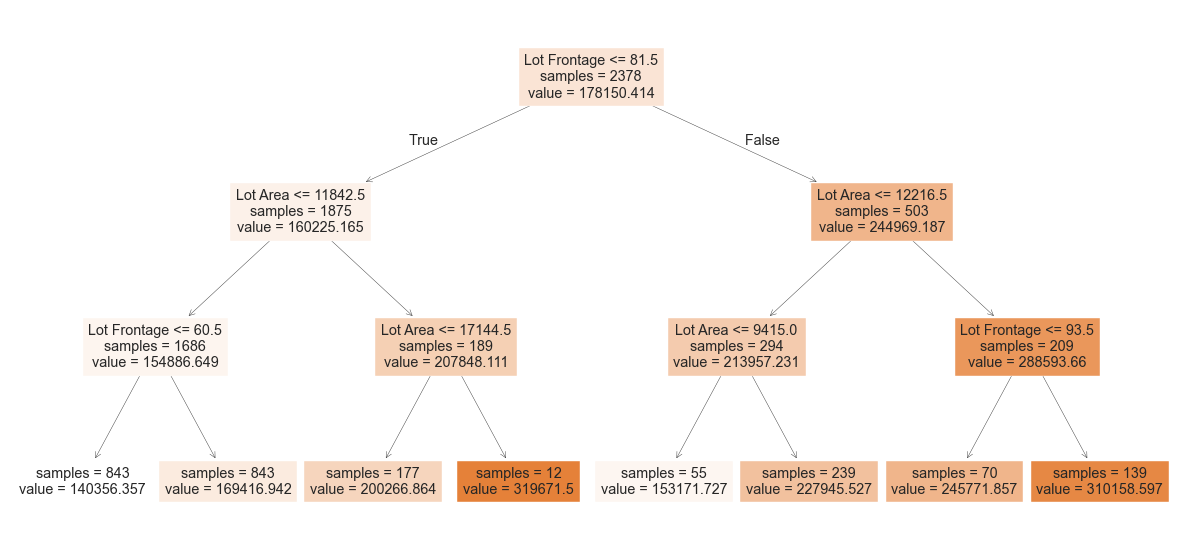

In [4]:
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    dt_reg, #дерево решений 
    feature_names=list(X.columns), #имена факторов
    filled=True, #расцветка
    impurity=False, #отображать ли неоднородность
);

Построим диаграмму рассеяния и визуализируем то, как дерево решений разделяет пространство факторов на прямоугольные области. Для этого шага мы реализовали функцию plot_decision_bound_regression():

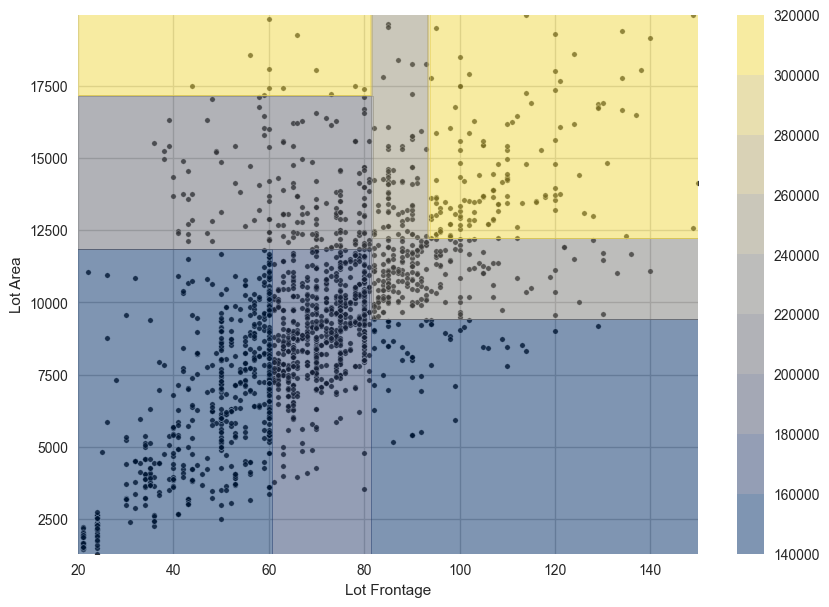

In [5]:
def plot_decision_bound_regression(X, y, model, fig):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 1)
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    y_pred = model.predict(X_net)
    y_pred = y_pred.reshape(xx1.shape)
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], s=15, color='black', alpha=0.8)
    contour = plt.contourf(xx1, xx2, y_pred, 10, cmap='cividis', alpha=0.5)
    fig.colorbar(contour)

# Визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
plot_decision_bound_regression(X, y, dt_reg, fig)

Давайте посмотрим на пример разделяющей поверхности дерева решений в случае задачи классификации ↓

?

Воспользуемся данными о банкнотах из Banknote Authentication Dataset.

Открыть примечание
Примечание. Данные были получены из изображений, которые соответствуют подлинным и поддельным образцам банкнот. Для оцифровки использовалась промышленная камера, обычно используемая для проверки отпечатков. Конечные изображения имеют размер 400x400 пикселей. 

Далее эти изображения были подвергнуты специальному вейвлет-преобразованию. Это преобразование, которое позволяет закодировать изображение в виде набора чисел. Если вам интересно подробнее изучить эту тему, рекомендуем прочесть данную статью.

Из преобразованных данных были извлечены различные статистические характеристики.

В качестве примера для визуализации из всех характеристик, описывающих изображения банкнот, будем использовать:

Variance (дисперсию);
Skewness (асимметрию).
Наша цель — предсказать, является ли банкнота фальшивой (Class): 1 — фальшивая, 0 — подлинная. Файл с данными вы можете скачать здесь.

Как обычно, подготовим обучающую выборку, отделив факторы X и целевую переменную y:

In [6]:
# Создаём обучающую выборку    
bill_data = pd.read_csv('data/bill_authentication.csv')
X = bill_data[['Variance', 'Skewness']]
y = bill_data['Class']

Создадим модель дерева решений для задачи классификации (класс DecisionTreeClassifier из модуля tree библиотеки sklearn) с максимальной глубиной 4 и обучим её.

In [7]:
# Инициализируем модель дерева решений с максимальной глубиной 4 и обучаем её
dt_clf = tree.DecisionTreeClassifier(max_depth=4)
dt_clf.fit(X.values, y)

DecisionTreeClassifier(max_depth=4)

Отследить то, как дерево решений строит свой прогноз, нам может помочь граф обученного дерева решений:



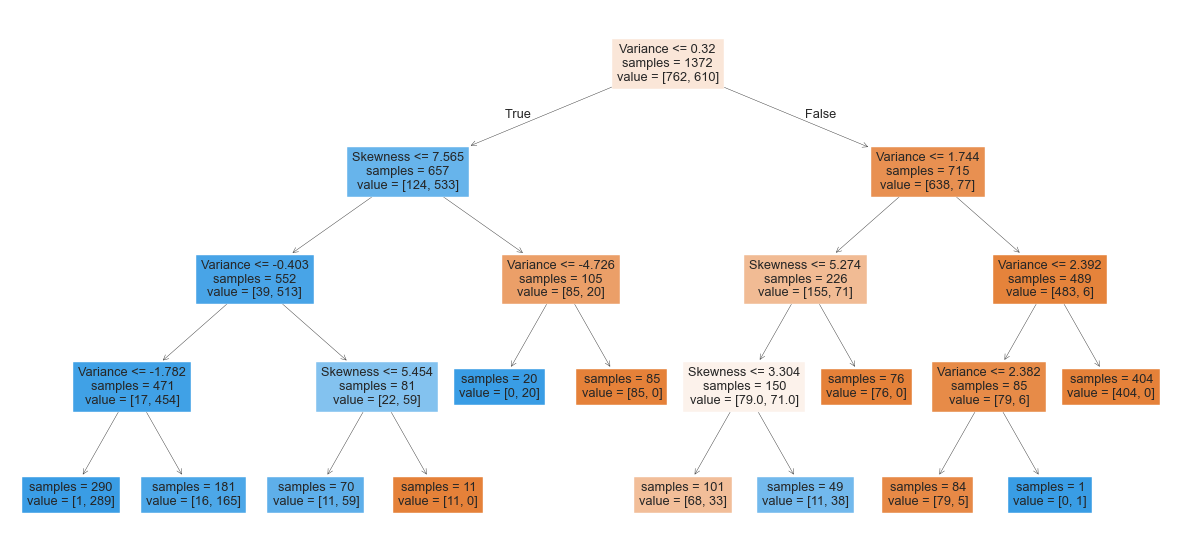

In [9]:
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    dt_clf, #дерево решений
    feature_names=list(X.columns), #имена факторов
    filled=True, #расцветка
    impurity=False, #отображать ли неоднородность
);

В результате построения дерева было образовано 12 областей (R1,R2,...,R12), каждая из которых соответствует одному из 12 листьев. В каждой из областей была рассчитана оценка вероятности принадлежности к каждому из классов — Pk. Класс объекта y^ определяется как класс с максимальной из этих вероятностей.

Построим диаграмму рассеяния и визуализируем то, как дерево решений разделяет пространство факторов на прямоугольные области. Для этого шага мы реализовали функцию plot_decision_bound_classification():

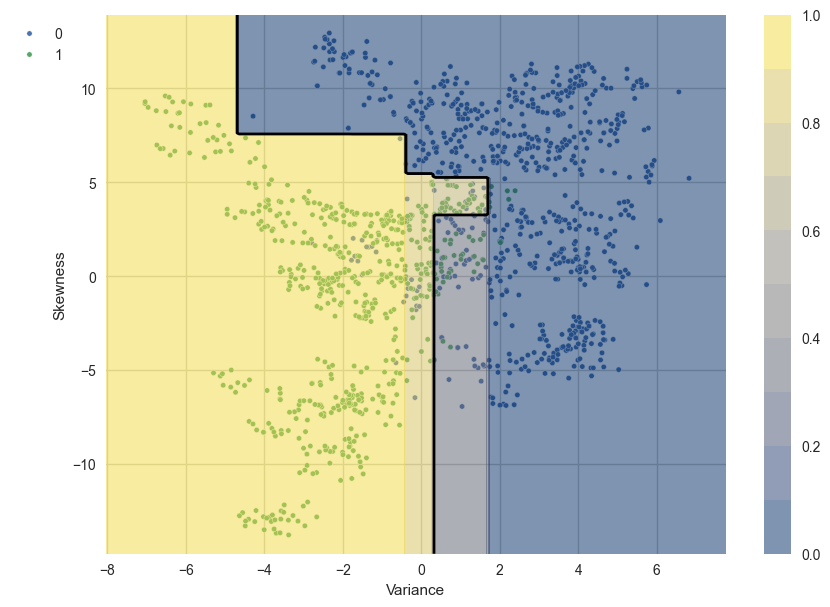

In [10]:
def plot_decision_bound_classification(X, y, model, fig):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    probs = model.predict_proba(X_net)[:, 1]
    probs = probs.reshape(xx1.shape)
    
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, s=15, alpha=1)
    contour = plt.contourf(xx1, xx2, probs, 10, cmap='cividis', alpha=0.5)
    bound = plt.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    fig.colorbar(contour)
    plt.legend(bbox_to_anchor=(-0.05, 1))
# Визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
plot_decision_bound_classification(X, y, dt_clf, fig)

Выше представлена тепловая карта вероятностей принадлежности к классу фальшивых банкнот — P^1 (они отражены на тепловой шкале справа от диаграммы — области, для которых вероятности закрашены одинаковым цветом). Банкноты, для которых данная вероятность P1>0.5, дерево считает фальшивыми, а остальные — подлинными.

Удобнее будет оформить полученный алгоритм в виде функции find_candidates_for_thresholds(). Она будет принимать на вход фактор x и целевую переменную y и возвращать кандидатов в пороговые значения для y в виде numpy-массива:


In [11]:
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

# print(find_candidates_for_thresholds(data['age'], data['loan']))
# print(find_candidates_for_thresholds(data['income'], data['loan']))
# [17.5 19.  22.5 30.  34.5 43.5]
# [23.5 34.5 36.5 48.  64.5 72. ]

Задание 3.4
1 point possible (graded)

Дана часть датасета о домах в штате Айова, состоящая из 15 наблюдений:

ames_data = pd.read_csv('data/AmesHousing.csv')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
ames_sample = ames_data[['Lot Frontage', 'Lot Area', 'SalePrice']].sample(
    n=15, #количество объектов
    random_state=42, #генератор случайных чисел
    ignore_index=True #сбрасываем счетчик индекса
)

Найдите уникальных кандидатов на пороговое значение  t  для фактора  x1  (Lot Frontage).

Выберите верный вариант ответа:

[50, 56, 60, 62, 68, 70, 72, 80, 92, 96, 106]
**[53, 58, 61, 65, 69, 71, 76, 86, 94, 101]**
[56, 60, 62, 68, 70, 72, 80, 92, 96, 106]
[5508, 7153, 7425, 7949, 8405.5, 8526.5, 8850, 9137.5, 9466, 10051.5, 10507, 10834, 11365, 12288]


In [12]:
ames_data = pd.read_csv('data/AmesHousing.csv')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
ames_sample = ames_data[['Lot Frontage', 'Lot Area', 'SalePrice']].sample(
    n=15, #количество объектов
    random_state=42, #генератор случайных чисел
    ignore_index=True #сбрасываем счетчик индекса
)

print(find_candidates_for_thresholds(ames_sample['Lot Frontage'], ames_sample['SalePrice']))

[ 53.  58.  61.  65.  69.  71.  76.  86.  94. 101.]


### Задание 3.5
1 point possible (graded)

Для части датасета о домах в Айове из предыдущего задания найдите уникальных кандидатов на пороговое значение  t  для фактора  x2  (Lot Area).

Выберите верный вариант ответа:

**[5508, 7153, 7425, 7949, 8405.5, 8526.5, 8850, 9137.5, 9466, 10051.5, 10507, 10834, 11365, 12288]**
[53, 58, 61, 65, 69, 71, 76, 86, 94, 101]
[4060, 6956, 7350, 7500, 8398, 8413, 8640, 9060, 9215, 9717, 10386, 10628, 11040, 11690, 12886]
[56, 60, 62, 68, 70, 72, 80, 92, 96, 106]


In [13]:
print(find_candidates_for_thresholds(ames_sample['Lot Area'], ames_sample['SalePrice']))

[ 5508.   7153.   7425.   7949.   8405.5  8526.5  8850.   9137.5  9466.
 10051.5 10507.  10834.  11365.  12288. ]


# Задание 4.3

3 points possible (graded)

Дана часть датасета о домах в штате Айова, состоящая из 15 наблюдений:

In [15]:
ames_data = ames_data[(ames_data["Lot Frontage"] <=150) & (ames_data["Lot Area"] <=20000)]

ames_sample = ames_data[["Lot Frontage", "Lot Area", "SalePrice"]].sample(
    n=15, random_state=42, ignore_index=True
)

X = ames_sample[["Lot Frontage", "Lot Area"]]
y = ames_sample["SalePrice"]

Найдите оптимальные для построения решающего пня параметры разбиения j и t. В качестве критерия информативности используйте квадратичную ошибку.

Если вы хотите попрактиковаться в использовании формул, можно проделать операцию построения дерева решений вручную.

Примечание. Для самопроверки обучите на данной части датасета дерево решений из sklearn с максимальной глубиной 1, критерием информативности 'squared_error' и параметром random_state = 0 и визуализируйте его граф.

In [16]:
def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred) ** 2).mean()

def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params


In [17]:
# Находим оптимальные параметры разбиения
optimal_split_params = best_split(X, y, criterion=squared_error)
print('Optimal j: {}'.format(optimal_split_params[0]))
print('Optimal t: {}'.format(optimal_split_params[1]))

Optimal j: 0
Optimal t: 71.0


3. Чему равно значение взвешенной неоднородности после разбиения при найденных оптимальных параметрах сплита? Ответ округлите до целого числа.

In [ ]:
# Вычисляем взвешенную неоднородность при оптимальных параметрах сплита
weighted_impurity = calculate_weighted_impurity(X, y, optimal_split_params, criterion=squared_error)
print(f'Взвешенная неоднородность: {weighted_impurity}')
print(f'Взвешенная неоднородность (округлено до целого): {int(round(weighted_impurity))}')


Взвешенная неоднородность: 1414654917.0222223
Взвешенная неоднородность (округлено до целого): 1414654917


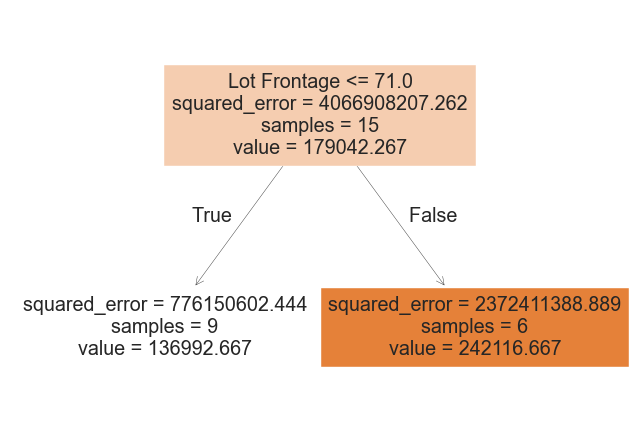

In [19]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем ее
dt = tree.DecisionTreeRegressor(
    max_depth=1, #глубина
    criterion='squared_error', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt.fit(X, y)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

## Задание 4.5
3 points possible (graded)

Дана часть датасета о банкнотах, состоящая из 15 наблюдений:

In [23]:
bill_data = pd.read_csv('data/bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

In [27]:
X.head(5)

,Variance,Skewness
0,1.569100,6.3465
1,-0.278020,8.1881
2,0.051979,7.0521
3,-1.755900,11.9459
4,2.428700,9.3821


Найдите оптимальные для построения решающего пня параметры разбиения j и t. Для этого воспользуйтесь функцией best_split(), которую мы реализовали ранее. В качестве критерия информативности используется энтропию Шеннона.

Если вы хотите попрактиковаться в использовании формул, можно проделать операцию построения дерева решений вручную.

In [33]:
def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy

optimal_split_params = best_split(X, y, criterion=entropy)


print(f'Optimal j: {optimal_split_params[0]}')
column_name = X.columns[optimal_split_params[0]]  # имя колонки в X
print(f'Имя колонки: {column_name}')
print(f'Optimal t: {optimal_split_params[1]:.3f}')

# Вычисляем взвешенную неоднородность при оптимальных параметрах сплита
weighted_impurity = calculate_weighted_impurity(X, y, optimal_split_params, criterion=entropy)
print(f'Взвешенная неоднородность: {weighted_impurity:.2f}')


Optimal j: 1
Имя колонки: Skewness
Optimal t: 3.221
Взвешенная неоднородность: 0.46


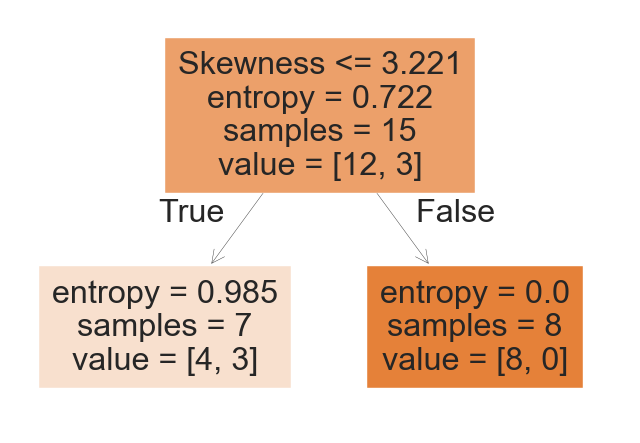

In [35]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем ее
# ВАЖНО: Для задачи классификации используем DecisionTreeClassifier, а не DecisionTreeRegressor
# Энтропия Шеннона (entropy) используется только для классификации
dt = tree.DecisionTreeClassifier(
    max_depth=1, #глубина
    criterion='entropy', #критерий информативности (энтропия Шеннона)
    random_state=0 #генератор случайных чисел
)
dt.fit(X, y)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

## Задание 5.3
2 points possible (graded)
Дана часть датасета о банкнотах, состоящая из 15 наблюдений:

In [36]:
bill_data = pd.read_csv('data/bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

Постройте дерево решений на обучающей выборке с помощью функции build_decision_tree(). В качестве критерия информативности используйте энтропию Шеннона.

Примечание. Для самопроверки обучите на данной части датасета дерево решений с неограниченной максимальной глубиной и визуализируйте его граф. Чтобы получить тот же результат, установите параметр random_state = 0.

1. Сколько вершин дерева используют в качестве признака разбиения фактор  (Variance)?


 
2. Чему равна глубина полученного дерева?

In [ ]:
class Node:
    def __init__(self, left=None, 
                 right=None, value=None, 
                 split_params=None, impurity=None,
                 samples=None, is_leaf=False):
        self.left = left
        self.right = right
        self.split_params = split_params
        self.value = value
        self.impurity = impurity
        self.samples = samples
        self.is_leaf = is_leaf
        
def create_leaf_prediction(y):
    value = y.mode()[0]
    return value

def stopping_criterion(X, y, criterion):
    return criterion(y) == 0

def build_decision_tree(X, y, criterion):
    if stopping_criterion(X, y, criterion):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=criterion)
        X_left, y_left, X_right, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion)
        right = build_decision_tree(X_right, y_right, criterion)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    
    return node

def print_decision_tree(node, depth=0):
    depth += 1
    if node.is_leaf:
        print('   ' * depth, 'class: {}'.format(node.value))
    else:
        print('   ' * depth, 'feature_{} <= {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.left, depth=depth)
        print('   ' * depth, 'feature_{} > {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.right, depth=depth)

def get_tree_depth(node, current_depth=0):
    """Вычисляет максимальную глубину дерева"""
    if node.is_leaf:
        return current_depth
    else:
        left_depth = get_tree_depth(node.left, current_depth + 1)
        right_depth = get_tree_depth(node.right, current_depth + 1)
        return max(left_depth, right_depth)

        
# Строим дерево решений и выводим его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy)
print_decision_tree(decision_tree)

# Вычисляем глубину дерева
tree_depth = get_tree_depth(decision_tree)
print(f'\nГлубина дерева: {tree_depth}')

    feature_1 <= 3.221:
       feature_0 <= 2.756:
          feature_0 <= -1.254:
             class: 0
          feature_0 > -1.254:
             feature_0 <= -0.063:
                class: 1
             feature_0 > -0.063:
                feature_0 <= 0.988:
                   class: 0
                feature_0 > 0.988:
                   class: 1
       feature_0 > 2.756:
          class: 0
    feature_1 > 3.221:
       class: 0

Глубина дерева: 5


: 

|--- feature_1 <= 3.22
|   |--- feature_0 <= 2.76
|   |   |--- feature_0 <= -1.25
|   |   |   |--- class: 0
|   |   |--- feature_0 >  -1.25
|   |   |   |--- feature_0 <= -0.06
|   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  -0.06
|   |   |   |   |--- feature_0 <= 0.99
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_0 >  0.99
|   |   |   |   |   |--- class: 1
|   |--- feature_0 >  2.76
|   |   |--- class: 0
|--- feature_1 >  3.22
|   |--- class: 0


Глубина дерева: 5


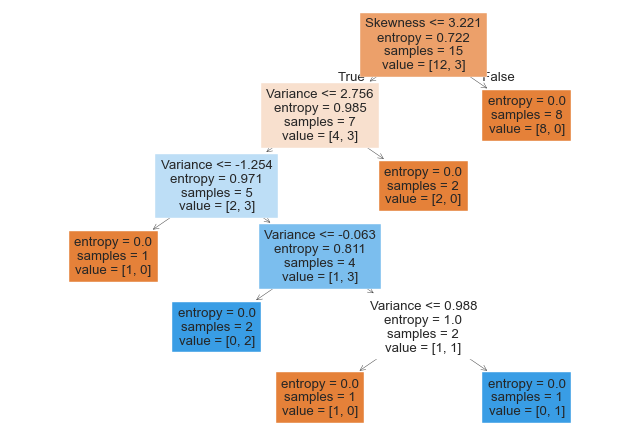

In [40]:
# Создаём модель дерева решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt.fit(X, y)
# Выводим дерево решений на экран в виде списка условий
print(tree.export_text(decision_tree=dt))

# Вычисляем фактическую глубину дерева
tree_depth = dt.tree_.max_depth
print(f'\nГлубина дерева: {tree_depth}')

tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);